<font size="+5">
(5), (6), (8) Below = things to check with Mihail!
</font>

In [2]:
# TODO:
# (1) Once the script is set in stone add this syntax to all of the function headers"
'''
describe what function does

@param file_name:
@param 2/...:

@return:

@throws: do this if throws an exception
'''
# 
# (2) get rid of idx += 1 use enumerate instead
#
# (3) Use np.zeros_like , np.array_like to make an array of the same size whenever possible
# 
# (4) when/if decide to normalize it do it for the entire stack not on a per image basis --> don't lose dynamic range
# 
# (6) what was the image from the  text that you sent me? --> x = (,) can do np.zeros([*x])
# 
# (7) processing: convolutions?, mean, median, sum (not the same bc if neuron is bigger the sum will be bigger but
# not a big deal if on a per neuron basis)?, thresholding?, time series?
# 
# (8) Is there a reason median across time takes so much longer than mean or sum across time? y

# IMPORTANT COMMENTS!!!
# # The median array is not the same as the mean or sum array
# But the mean and sum array for percentile cutoffs are the same --> DUHHHHH


'\ndescribe what function does\n\n@param file_name:\n@param 2/...:\n\n@return:\n\n@throws: do this if throws an exception\n'

In [ ]:
# NOTE: when wanting to save the results to a .npy file do:
# np.save('lab_200_masks_no_time_series_percentile_87', masks_200_percentile_87)

In [ ]:
# TODO: rewrite section 1 to be encapsulated by one function???

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import scipy
import skimage.io as skimage

from collections import defaultdict
from collections import namedtuple
from glob import glob
from random import shuffle
from scipy import signal
from scipy.ndimage import measurements

In [4]:
'''
@param lab_names: a list of all of the lab names as strings that appear in our file names i.e. '_p200'
@param files: a glob of files

@return lab_names_to_files: a defaultdict where the lab names are the keys and all of the file names that fall into that lab
are the values
'''
def seperate_file_names_by_lab(lab_names, files):
    lab_names_to_files = defaultdict(list)
    
    for file in files:
        lab_name_found = False
        for lab_name in lab_names:
            if re.search(lab_name, file):
                lab_names_to_files[lab_name].append(file)
                lab_name_found = True
        if not lab_name_found:
            print('error file name: ' + file + ' not found in lab names')
            
    return lab_names_to_files

In [5]:
INITIAL_DATA_GLOB = glob('/Users/sabera.talukder/Desktop/anithaTestData/*.tiff')
files = sorted(INITIAL_DATA_GLOB)

In [6]:
NUM_P200_FILES = 8000
NUM_P300_FILES = 2250
lab_names = ['_p200', '_p300']

# split data files based on lab name
lab_names_to_files = seperate_file_names_by_lab(lab_names, files)

# assert just checks to make sure the statement is true and if it is not returns the comment to its right
assert len(lab_names_to_files['_p200']) == NUM_P200_FILES, 'missing files'
assert len(lab_names_to_files['_p300']) == NUM_P300_FILES, 'missing files'

files_200 = np.array(lab_names_to_files['_p200'])
files_300 = np.array(lab_names_to_files['_p300'])

In [7]:
'''
@param file_name: a name of one file

@return int_list_C_Z_T_P: a list containing the integer values within the file name in the order C, Z, T, P

@notes:
-r signifies that the following argument is a string
-the '\d+' signifies that we are looking for a digit
'''
def find_integers_in_file_name(file_name):
    string_list_C_Z_T_P = re.findall(r'\d+', file_name)
    int_list_C_Z_T_P = list(map(int, string_list_C_Z_T_P))
    return int_list_C_Z_T_P

In [9]:
'''
@param file_names: a numpy array of file names

@return True / False: returns a True or False depending on whether or not the files in the numpy array are sorted by
their time value
'''
def verify_files_sorted_by_time(file_names):
    for idx in range(0, len(file_names)-1):
        first_file_vals = find_integers_in_file_name(file_names[idx])
        second_file_vals = find_integers_in_file_name(file_names[idx + 1])
        if not first_file_vals[2] < second_file_vals[2]:
            print('Time values are not in increasing order. The idx this occured at is: ' + str(idx))
            return False
    return True

In [10]:
print(verify_files_sorted_by_time(files_200))
print(verify_files_sorted_by_time(files_300))

True
True


In [48]:
'''
@param file_names: a numpy array of file names

@return: returns a 3D numpy array containing the images in the
correct time series order. Each image is a 2d numpy array within the 3D numpy array.
'''
def convert_file_names_to_img_arr(file_names):
    return np.array([skimage.imread(f) for f in file_names])

In [12]:
imgs_200 = convert_file_names_to_img_arr(files_200)

In [17]:
imgs_300 = convert_file_names_to_img_arr(files_300)

In [27]:
IMG_SHAPE_200 = imgs_200.shape[1:]
IMG_SHAPE_300 = imgs_300.shape[1:]

In [28]:
'''
@param neuron_mask_path: Is the path to the regions.json file that contains the information about all of the neuron
masks

@return regions: regions is a list of dictionaries. The length of regions (i.e. the # of dicts) is the # of pixels to
be filled in for each neuron. The key for every dict is 'coordinates' and the values are the pixel coordinates for
each mask.
'''
def read_in_neuron_masks(neuron_mask_path):
    with open(neuron_mask_path) as file:
        regions = json.load(file)
    return regions

In [29]:
regions_200 = read_in_neuron_masks('neurofinder.02.00/regions/regions.json')
regions_300 = read_in_neuron_masks('neurofinder.03.00/regions/regions.json')

In [30]:
'''
@param coords: A list of all of the pixel values in the form [[x1,y1],[x2,y2],...]
@param dims: A tuple of the 2d array dimensions of the mask, where the pixel coordinates will be filled in.

@ return mask: a 2d zeros numpy array where the shape of a neuron is filled in with pixel values of 1.
'''
def fill_in_pixel_vals(coords, dims):
    mask = np.zeros(dims)
    for coord in coords:
        mask[coord[0], coord[1]] = 1
    return mask

In [37]:
print(*IMG_SHAPE_200)

512 512


In [38]:
'''
@param regions: a list of dicts, each dict contains all of the coordinate values for one neuron mask
@param img_shape_tuple: a tuple of the 2d array dimensions of the mask

@return mask_array: a 3d array with dimensions: (# of neurons, x dim of mask, y dim of mask). Each 2D array within
the 3D array is the mask for one neuron, where neuron pixels = 1 and rest of array = 0.

@notes:
-this function calls fill_in_pixel_vals(coords, dims) to fill in the pixel vals
'''
def go_from_dict_vals_to_masks(regions, img_shape_tuple):
    KEY_FOR_MASK_DICTS = 'coordinates'
    # the *img_shape_tuple just makes it so that we can take the dimensions without unpacking the tuple like:
    # img_shape_tuple[0], img_shape_tuple[1]
    mask_array = np.zeros([len(regions), *img_shape_tuple])
    
#     TODO pick a better name than dictionary
    for idx, dictionary in enumerate(regions):
        mask_array[idx, :, :] = fill_in_pixel_vals(dictionary[KEY_FOR_MASK_DICTS],img_shape_tuple)
    return mask_array

In [39]:
masks_200 = go_from_dict_vals_to_masks(regions_200, IMG_SHAPE_200)
masks_300 = go_from_dict_vals_to_masks(regions_300, IMG_SHAPE_300)

In [43]:
# creating a namedtuple to be used in the get_neuron_mask_info(total_mask_array) function
neuron_mask = namedtuple('neuron_mask', ['num_neuron', 'num_pixels', 'x_min', 'y_min', 'x_max', 'y_max'])

In [44]:
'''
@param total_mask_array: a 3d array where each 2d slice is a mask for one neuron in that stack.

@return neuron_info: a list of namedtuples containing the index where the neuron appeared in the total mask, the
number of pixels in that mask, then x_min, y_min, x_max, y_max. The coordinates allow us to create a neuron bounding 
box
'''
def get_neuron_mask_info(total_mask_array):
    neuron_info = []
    for idx, mask in enumerate(total_mask_array):
        # returns the unique pixel values, and the number of times each of those pixel values appear in the img
        unique, counts = np.unique(mask, return_counts = True)
        # returns an array with x indicies, and an array with y indicies wherever the pixel was == 1
        where_one = np.where(mask == 1)
        neuron = neuron_mask(num_neuron=idx, num_pixels = counts[-1], x_min = np.min(where_one[0]), \
                             y_min = np.min(where_one[1]), x_max = np.max(where_one[0]), y_max = np.max(where_one[1]))
        neuron_info.append(neuron)
    return neuron_info

In [45]:
masks_200_info = get_neuron_mask_info(masks_200)
masks_300_info = get_neuron_mask_info(masks_300)

<font size='+3'>
^ UP until that point is processing and generating DATA
    <br>
    <br>
    We will call the previous section: Section 1
</font>

In [46]:
'''
@param filter_type: a string of the value 'median', 'mean', or 'sum'. This is the metric that we will use to compare
neurons to one another.

@param: neuron_2d_array: the 2d array that contains the true image values, but only for the pixels that count as being
part of the neuron

@return: returns float of the median, mean, or sum. OR prints an error if you didn't pass a valid filer type
'''
def neuron_image_evaluation(filter_type, neuron_2d_array):
    if filter_type == 'median':
        return np.median(neuron_2d_array)
    elif filter_type == 'mean':
        return np.mean(neuron_2d_array)
    elif filter_type == 'sum':
        return np.sum(neuron_2d_array)
    else:
        print('error did not pass a valid string argument')

In [50]:
'''
@param mask_info: the list of namedtuples that contains the neuron index in the mask array, the neuron's array, and
the bounding box information

@param total_mask_array: a 3d array of all of the masks for a full stack (#neurons, x_dim of masks, y_dim of masks)

@param img_stack: a 3d array of all of the imgs (#time_steps, x_dim of imgs, y_dim of imgs)

@param how_to_evaluate_neuron: which is the 'median', 'mean', 'sum' that the neuron_image_evaluation() requires

@return neuron_across_time_series: a 2d array with size (# of neurons, # of imgs in the time series). Each value in
the array is the median/mean/or sum of the pixels that fill the neuron bounding box in that img

@note:
-the x_dim of masks = the x_dim of imgs, the y_dim of masks = the y_dim of imgs
'''
def neuron_vals_across_time_series(mask_info, total_mask_array, img_stack, how_to_evaluate_neuron):
    neuron_across_time_series = np.zeros([total_mask_array.shape[0], img_stack.shape[0]])
    
    for mask_idx, neuron in enumerate(mask_info):
        cur_info = mask_info[mask_idx]
        mask = total_mask_array[mask_idx, cur_info.x_min : cur_info.x_max, cur_info.y_min : cur_info.y_max]
        
        for time_idx, img in enumerate(img_stack):
            img_segment = img[cur_info.x_min : cur_info.x_max, cur_info.y_min : cur_info.y_max]
            neuron = mask * img_segment
            m_m_or_s_val = neuron_image_evaluation(how_to_evaluate_neuron, neuron)
            neuron_across_time_series[mask_idx, time_idx] = m_m_or_s_val
            
    return neuron_across_time_series

In [49]:
'''
@param neuron_and_time_stack: 2d array with dims (# of neurons, # of imgs in the time series)

@param percentile: a int or float that signifies the percentile cutoff we will apply to each neuron's time series

@return percentile_val_per_neuron: a 1d array (# neurons, 1) with the actual percentile value per neuron. i.e. if we
want the 85th percentile for the median that might coorespond to pixel value of 13 for one neuron across its time
series
'''
def compute_percentile_per_neuron(neuron_and_time_stack, percentile):
    NUM_NEURONS = neuron_and_time_stack.shape[0]
    percentile_val_per_neuron = np.zeros([NUM_NEURONS, 1])
    for row in range(0, NUM_NEURONS):
        percentile_val = np.percentile(neuron_and_time_stack[row, :], percentile)
        percentile_val_per_neuron[row, 0] = percentile_val
    return percentile_val_per_neuron

In [52]:
'''
@param percentile_vals: a 1d array (# neurons, 1) with the actual percentile value per neuron

@param neuron_across_time_series: a 2d array with size (# of neurons, # of imgs in the time series). Each value in 
the array is the median/mean/or sum of the pixels that fill the neuron bounding box in that img

@return neuron_mask_present_in_img: a 2d array with size (# of neurons, # of imgs in the time series) [SAME size as
the neuron_across_time_series array] if the value in the array is 1 it signifies that that neuron is above the Xth
percentile across that neuron's time series, if the value in the array is 0 it signififes that that neuron is below
the Xth percentile for that neuron's time series.
'''
def array_where_neuron_val_above_percentile(percentile_vals, neuron_across_time_series):
    NUM_NEURONS = percentile_vals.shape[0] # = neuron_across_time_series.shape[0]
    NUM_IMGS_IN_TIME_SERIES = neuron_across_time_series.shape[1]
    neuron_mask_present_in_img = np.zeros_like(neuron_across_time_series)
    for row in range(0, NUM_NEURONS):
        percential_val = percentile_vals[row, 0]
        for col in range(0, NUM_IMGS_IN_TIME_SERIES):
            if neuron_across_time_series[row, col] > percential_val:
                neuron_mask_present_in_img[row, col] = 1
    return neuron_mask_present_in_img

In [53]:
'''
@param median_array: 2d array of dims (# of neurons, # of imgs in the time series). 1 values in array indicate that
the median is above the Xth percentile

@param mean_array: 2d array of dims (# of neurons, # of imgs in the time series). 1 values in array indicate that
the mean is above the Xth percentile

@return above_percentile_in_med_mean: returns 2d array of dims (# of neurons, # of imgs in the time series) where the
median array has been multipled by the mean array. Since the arrays are all 0s or 1s if we multiply them together 
only the neuron values that are above the Xth percentile for both metrics will be represented
'''
def combine_median_mean(median_array, mean_array):
    above_percentile_in_med_mean = median_array * mean_array
    return above_percentile_in_med_mean

In [193]:
'''
@param neuron_vs_time_series: 2d array dim (# neurons, total # of time stamps). Demonstrates which neurons are high
during which time series

@param total_time_filter_len: The length of time series in which we want to check how many times a neuron went high.
If input an even number i.e. n will actually look at the total_time_fitler_len of n + 1. I.e. 2 --> 3, 4 --> 5.

@return time_filtered_neuron_vs_time_series: returns a 2d array dim (# neurons, total # of time stamps). Demonstrates 
which neurons are high during which time series with the applied time filter

@note:
-if input total_time_filter_len == 0 or 1 just returns back neuron_vs_time_series --> because values of 0, 1 imply
that you do not want your data to be time filtered
'''
def time_filter(neuron_vs_time_series, total_time_filter_len):
    
    if total_time_filter_len == 0 or total_time_filter_len == 1:
        return neuron_vs_time_series
    
    time_filtered_neuron_vs_time_series = np.zeros_like(neuron_vs_time_series)
    NUM_NEURONS = neuron_vs_time_series.shape[0]
    TOTAL_TIME_SERIES = neuron_vs_time_series.shape[1]
    len_on_either_side = int(total_time_filter_len/2 +.5)
    
    for neuron in range(0, NUM_NEURONS):
        for time_stamp in range(0, TOTAL_TIME_SERIES):
            if time_stamp - len_on_either_side >= 0:
                in_bounds_to_left = True
            else:
                in_bounds_to_left = False
                
            if time_stamp + len_on_either_side <= TOTAL_TIME_SERIES:
                in_bounds_to_right = True
            else:
                in_bounds_to_right = False

            
            # out of bounds on left, in bounds on right
            if not in_bounds_to_left & in_bounds_to_right:
                segment_to_check = neuron_vs_time_series[neuron][0 : time_stamp+len_on_either_side]
                # there are multiple values of 1 for this neuron in this time window so this value should stay 1
                if np.count_nonzero(segment_to_check) > 1:
                    if neuron_vs_time_series[neuron, time_stamp] == 1:
                        time_filtered_neuron_vs_time_series[neuron, time_stamp] = 1
                # there is only one value of 1 for this neuron in this time window so this value should get set to 0
                else:
                    time_filtered_neuron_vs_time_series[neuron, time_stamp] = 0
                                         
            # in bounds on left, out of bounds on right
            if not in_bounds_to_right & in_bounds_to_left:
                segment_to_check = neuron_vs_time_series[neuron][time_stamp-len_on_either_side :]
                # there are multiple values of 1 for this neuron in this time window so this value should stay 1
                if np.count_nonzero(segment_to_check) > 1:
                    if neuron_vs_time_series[neuron, time_stamp] == 1:
                        time_filtered_neuron_vs_time_series[neuron, time_stamp] = 1
                # there is only one value of 1 for this neuron in this time window so this value should get set to 0
                else:
                    time_filtered_neuron_vs_time_series[neuron, time_stamp] = 0
            
            # in bounds on left, in bounds on right
            if in_bounds_to_left & in_bounds_to_right:
                segment_to_check = neuron_vs_time_series[neuron][time_stamp-len_on_either_side : time_stamp+len_on_either_side]
                # there are multiple values of 1 for this neuron in this time window so this value should stay 1
                if np.count_nonzero(segment_to_check) > 1:
                    if neuron_vs_time_series[neuron, time_stamp] == 1:
                        time_filtered_neuron_vs_time_series[neuron, time_stamp] = 1
                # there is only one value of 1 for this neuron in this time window so this value should get set to 0
                else:
                    time_filtered_neuron_vs_time_series[neuron, time_stamp] = 0
    
    return time_filtered_neuron_vs_time_series

In [63]:
'''
all_masks = return_total_masks(np.transpose(combined_percentiles), total_mask_array, img_stack)

@param array_masks_per_img: 2d array of dims (# of imgs in the time series, # of neurons). i.e. the transpose of what
the combine_median_mean() returns. 

@param all_masks: 3d array that contains all of the masks for an image stack. (# neurons, x_dim, y_dim)

@param all_imgs: 3d array that contains all of the images in an image stack (# of images in time series, x_dim, y_dim)

@return total_masks_for_imgs: 3c array of dims (# of images in time series, x_dim, y_dim). Each slice in this 3d
array contains the mask with neurons above the Xth percentile for each image in the time series
'''
def return_total_masks(array_masks_per_img, all_masks, all_imgs):
    NEURON_NUM = all_masks.shape[0]
    TIME_SERIES_NUM = all_imgs.shape[0]
    IMG_X_DIM = all_imgs.shape[1] #This is the same dimension as all_masks.shape[1]
    IMG_Y_DIM = all_imgs.shape[2] #This is the same dimension as all_masks.shape[2]
    total_masks_for_imgs = np.zeros([TIME_SERIES_NUM, IMG_X_DIM, IMG_Y_DIM])
    
    for row in range(0, TIME_SERIES_NUM):
        total_mask = np.zeros([IMG_X_DIM, IMG_Y_DIM])
        for col in range(0, NEURON_NUM):
            if array_masks_per_img[row, col] == 1:
                total_mask = total_mask + all_masks[col, :, :]
        total_masks_for_imgs[row, :, :] = total_mask
    return total_masks_for_imgs

<font size='+3'>
^ UP until that point extracting masks based on a percentile value
    <br>
    <br>
    That was Section 2.
</font>

In [69]:
'''
@params neuron_vs_time_series: a 2d array of dims (# of neurons, # of imgs in the time series) The arrays is all 0s 
or 1s. 1 indicates neuron is above Xth percentile in that time slice

@return True / False: returns true if every neuron is high in at least 1 image in the time series. returns false if
there is a neuron that is not present across a time series.

@note:
-it is a problem if this check returns false, because every neuron should be high at least once if it belongs in the
data set.
'''
    
def neuron_high_at_least_once_in_time_series(neuron_vs_time_series):
    for neuron_num in range(0, neuron_vs_time_series.shape[0]):
        # there is a neuron that is not present even once
        if not np.isin(1, neuron_vs_time_series[neuron_num, :]):
            print('there is a neuron that is not high at least once' + str(neuron_num))
            return False
    return True
    

In [217]:
'''
@param percentile_selectivity: int or float that demonstrates what percentile selectivity we are going to cutoff at

@param time_filter_length: an int that gives the total number of time series we will filter against. If pass 0 or 1 
will not compute a time filter. Change to be greater or equal to 2 to get a time filtered result.

@param mask_info: a list of namedtuples containing the index where the neuron appeared in the total mask, the
number of pixels in that mask, then x_min, y_min, x_max, y_max. The coordinates allow us to create a neuron bounding 
box

@param total_mask_array: a 3d array dims (# neurons, x_dim, y_dim) each slice of the 3d array contains a mask for 1
neuron

@param img_stack: a 3d array dims (# time steps, x_dim, y_dim) each slice of the 3d array contains an in order image
from the time series
'''
def mask_for_each_img_in_time_series(percentile_selectivity, time_filter_length, mask_info, total_mask_array, img_stack):
    
    TOTAL_NUM_TIME_STEPS = img_stack.shape[0]
    TOTAL_NUM_NEURONS = total_mask_array.shape[0]

    neuron_med_across_time = neuron_vals_across_time_series(mask_info, total_mask_array, img_stack, 'median')
    neuron_mean_across_time = neuron_vals_across_time_series(mask_info, total_mask_array, img_stack, 'mean')

    percentile_val_per_neuron_med = compute_percentile_per_neuron(neuron_med_across_time, percentile_selectivity)
    percentile_val_per_neuron_mean = compute_percentile_per_neuron(neuron_mean_across_time, percentile_selectivity)

    neuron_med_above_percentile = array_where_neuron_val_above_percentile(percentile_val_per_neuron_med, neuron_med_across_time)
    neuron_mean_above_percentile = array_where_neuron_val_above_percentile(percentile_val_per_neuron_mean, neuron_mean_across_time)
    
    combined_percentiles = combine_median_mean(neuron_med_above_percentile, neuron_mean_above_percentile)
    
    if neuron_high_at_least_once_in_time_series(combined_percentiles) == False:
        print('error, some neurons are not present even before time filtering')
        
    time_filtered_combined_percentile = time_filter(combined_percentiles, time_filter_length)
    
    if neuron_high_at_least_once_in_time_series(time_filtered_combined_percentile) == False:
        print('error, some neurons are not present AFTER time filtering')
    
    all_masks = return_total_masks(np.transpose(time_filtered_combined_percentile), total_mask_array, img_stack)
    
    return all_masks
    

In [150]:
#TODO: make sure the time component step of what I am doing actually works!!!
#  --> should be working!!!

In [159]:
percentile_selectivity = 87
time_filter_length = 0
mask_info = masks_200_info
total_mask_array = masks_200
img_stack = imgs_200



TOTAL_NUM_TIME_STEPS = img_stack.shape[0]
TOTAL_NUM_NEURONS = total_mask_array.shape[0]

neuron_med_across_time = neuron_vals_across_time_series(mask_info, total_mask_array, img_stack, 'median')
neuron_mean_across_time = neuron_vals_across_time_series(mask_info, total_mask_array, img_stack, 'mean')

percentile_val_per_neuron_med = compute_percentile_per_neuron(neuron_med_across_time, percentile_selectivity)
percentile_val_per_neuron_mean = compute_percentile_per_neuron(neuron_mean_across_time, percentile_selectivity)

neuron_med_above_percentile = array_where_neuron_val_above_percentile(percentile_val_per_neuron_med, neuron_med_across_time)
neuron_mean_above_percentile = array_where_neuron_val_above_percentile(percentile_val_per_neuron_mean, neuron_mean_across_time)
    
combined_percentiles = combine_median_mean(neuron_med_above_percentile, neuron_mean_above_percentile)
    
if neuron_high_at_least_once_in_time_series(combined_percentiles) == False:
    print('error, some neurons are not present!')
        
time_filtered_combined_percentile = time_filter(combined_percentiles, time_filter_length)

if neuron_high_at_least_once_in_time_series(combined_percentiles) == False:
    print('error, some neurons are not present!')

In [194]:
time_filter_length = 5

time_filtered_combined_percentile_5 = time_filter(combined_percentiles, time_filter_length)

In [195]:
unique_0, counts_0 = np.unique(time_filtered_combined_percentile, return_counts=True)
unique_5, counts_5 = np.unique(time_filtered_combined_percentile_5, return_counts=True)

In [197]:
print(unique_0, counts_0)
print(unique_5, counts_5)

[0. 1.] [1429646  146354]
[0. 1.] [1454635  121365]


In [200]:
print(time_filtered_combined_percentile_5[0][7870:7900])
print(time_filtered_combined_percentile[0][7870:7900])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 1. 0.]


In [201]:
all_masks_0 = return_total_masks(np.transpose(time_filtered_combined_percentile), total_mask_array, img_stack)
print('in between')
all_masks_5 = return_total_masks(np.transpose(time_filtered_combined_percentile_5), total_mask_array, img_stack)

in between


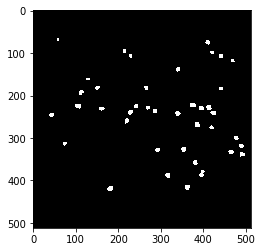

In [214]:
plt.imshow(all_masks_0[1], cmap='gray')

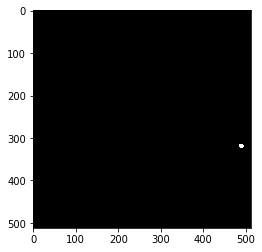

In [213]:
plt.imshow(all_masks_5[1], cmap='gray')

In [130]:
c[x_min:x_max, y_min:y_max]

array([], shape=(303, 0), dtype=float64)

In [104]:
indicies = []
for row in range(0, time_filter_0[0].shape[0]):
    for col in range(0, time_filter_0[0].shape[1]):
        if not time_filter_0[0][row, col] == time_filter_5[0][row, col]:
            indicies.append([row, col])

In [112]:
x_min = indicies[0][0]
x_max = indicies[0][0]

y_min = indicies[0][1]
y_max = indicies[0][1]

for item in range(0, len(indicies)):
    if indicies[item][0] > x_max:
        x_max = indicies[item][0]
    if indicies[item][0] < x_min:
        x_min = indicies[item][0]
        
    if indicies[item][1] > y_max:
        y_max = indicies[item][0]
    if indicies[item][1] < y_min:
        y_min = indicies[item][0]
        

In [113]:
print(x_min, x_max, y_min, y_max)

131 434 434 397


In [98]:
np.array_equal(time_filter_5, time_filter_0)

False

In [ ]:
# ONCE time component is all fixed --> make a movie then I am done

In [71]:
masks_200_percentile_87 = temp_which_percentile(87, masks_200_info, masks_200, imgs_200)

In [49]:
masks_300_percentile_87 = temp_which_percentile(87, masks_300_info, masks_300, imgs_300)

In [ ]:
def plot_total_mask_over_img_slice(total_masks, all_imgs, img_idx):
    plt.imshow(all_imgs[img_idx,:,:], cmap = 'gray')
    Mask = np.ma.masked_array(total_masks[img_idx, :, :] == 0, total_masks[img_idx, :, :])
    plt.imshow(Mask, cmap = 'hsv',alpha = .5)

In [1]:
IMG_TO_PLOT = 2158
plt.figure(figsize=(30, 50))
plt.subplot(1,3,1)
plt.title("All Possible Masks Overlaid on Image", fontsize=25)
plt.imshow(imgs_300[IMG_TO_PLOT], cmap = 'gray')
Mask = np.ma.masked_array(masks_300.sum(axis=0) == 0, masks_300.sum(axis=0))
plt.imshow(Mask, cmap = 'hsv', alpha = .5)

plt.subplot(1,3,2)
plt.title("Masks at 87th Percentile Overlaid on Image", fontsize=25)
plot_total_mask_over_img_slice(all_masks_0[0], imgs_300, IMG_TO_PLOT)

plt.subplot(1,3,2)
plt.title("Masks at 87th Percentile Overlaid on Image", fontsize=25)
plot_total_mask_over_img_slice(all_masks_5[0], imgs_300, IMG_TO_PLOT)

NameError: name 'plt' is not defined

In [ ]:
# TODO fxn to save the whole movie

In [ ]:
from matplotlib import animation

x = np.arange(0, 490, 1)
y = np.arange(0, 498, 1)
X, Y = np.meshgrid(x, y)

nFrames = imgs_300.shape[0]

# # Set up plotting
fig = plt.figure()
ax = plt.axes()  

# Animation function
def animate(i): 
    z = imgs_300[i,:,:]
    cont = plt.contourf(X, Y, z)
    
    return cont

anim = animation.FuncAnimation(fig, animate, frames=nFrames)

mywriter = animation.FFMpegWriter()
anim.save('animation.mp4',writer=mywriter)